In [ ]:
"""
[V1]
*  

[TODO]
* Add holiday

"""

In [47]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
from prophet import Prophet
import gc
from joblib import Parallel, delayed
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

In [2]:
#from hts.utilities.load_data import load_hierarchical_sine_data
#from datetime import datetime

#s, e = datetime(2022, 6, 1), datetime(2023, 7, 31)
#hsd = load_hierarchical_sine_data(start=s, end=e, n=10000)
#hsd['ds'] = hsd.index.strftime("%Y-%m-%d")
#df = hsd.groupby(['ds']).sum().reset_index(drop=False).sort_values(by='ds', ascending=True)
df = pd.read_csv('./input/data.csv', sep=',', index_col=0)
df.rename(columns={'date': 'ds', 'object_code': 'id', 'trips': 'y'}, inplace=True)
df.head()

,ds,id,y
0,2021-11-14,010Y,2034393
1,2021-11-15,010Y,1665905
2,2021-11-16,010Y,1559682
3,2021-11-17,010Y,1281395
4,2021-11-18,010Y,1088840


In [20]:
#df_pre = pd.DataFrame(columns=['ds', 'y', 'id'])
#for i in range(1, df.shape[1]):
#    tmp_df = df.iloc[:, [0,i]]
#    tmp_df.rename(columns={tmp_df.columns[1]: 'y'}, inplace=True)
#    tmp_df['id'] = df.columns[i]
#    df_pre = pd.concat([df_pre, tmp_df], axis=0)

In [3]:
class DataProcess(object):
    def __init__(self):
        pass

    def data_tranform(self, data):
        # print('transform dataset shape is {}'.format(data.shape))
        data = data.groupby(['id']).filter(lambda x: len(x) >= 14)
        ts_key = [i for i in data.columns if i != 'y']
        data.drop_duplicates(subset=ts_key, inplace=True)
        data.sort_values(ts_key, ascending=len(ts_key) * [True], inplace=True)
        data['ds'] = data['ds'].astype(str)
        data = data[data['ds'] != 'nan']
        data['y'] = data['y'].fillna(0)
        data['ds'] = data['ds'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        data = data.dropna(axis=0)
        return data

    def replace_fill(self, data, name):
        data['ds'] = pd.to_datetime(data['ds'], format='%Y-%m-%d')
        data['y'] = data['y'].astype(float)
        data.loc[data['y'] <= 0, 'y'] = np.NaN
        low = data[data['y'] > 0]['y'].quantile(0.05)
        high = data[data['y'] > 0]['y'].quantile(0.995)
        data.loc[data['y'] < low, 'y'] = low
        data.loc[data['y'] > high, 'y'] = high
        data.loc[data['y'].isnull(), 'y'] = data['y'].shift(1).values[0]
        data.loc[data['y'].isnull(), 'y'] = data['y'].shift(7).values[0]
        data.loc[data['y'].isnull(), 'y'] = data['y'].shift(14).values[0]
        data.loc[data['y'].isnull(), 'y'] = data['y'].interpolate(methon='nearest', order=2)
        data['id'] = name
        return data

    def multi_fill(self, data):
        data['id'] = data['id'].astype(str)
        data_grouped = data.groupby(data.id)
        use_cpu = cpu_count() // 2
        results = Parallel(n_jobs=use_cpu)(delayed(self.replace_fill)(group, name) for name, group in data_grouped)
        p_predict = pd.concat(results)
        del data
        gc.collect()
        return p_predict

    def predict_cap(self, data, result, columns):
        data_list = set(result['id'].unique())
        data_df = data[data['id'].isin(data_list)][['id', 'y']]
        for i in data_df['id'].unique():
            low = (1 + 0.1) * data_df[data_df['id'] == i]['y'].min()
            hight = (1 + 1) * data_df[data_df['id'] == i]['y'].max()
            result.loc[(result['id'] == i) & (result[columns] < low), columns] = low
            result.loc[(result['id'] == i) & (result[columns] > hight), columns] = hight
        del data_df, data
        gc.collect()
        return result

    def date_between(self, date_start_str, date_end_str):
        d_start = time.strptime(date_start_str, "%Y-%m-%d")
        d_end = time.strptime(date_end_str, "%Y-%m-%d")
        date_result = (datetime.datetime(d_end[0], d_end[1], d_end[2]) - datetime.datetime(d_start[0], d_start[1],
                                                                                            d_start[2])).days
        return date_result

class ParallelFunc(object):
    def __init__(self, data, parallel_type, model_func):
        self.data = data
        self.parallel_type = parallel_type
        self.model_func = model_func

    def apply_process(self, group, holiday):
        data, name = group
        df = self.model_func(data, name, holiday)
        return df

    def multi_processes(self):
        pool = Pool(100)
        partial_parallel = partial(self.apply_process)
        result = pd.concat(pool.map(partial_parallel, [(group, name) for name, group in self.data.groupby('id')]),
                            ignore_index=True)
        pool.close()
        pool.join()
        return result

    def multi_groupby(self):
        data = self.data
        data['id'] = data['id'].astype(str)
        df_result = pd.DataFrame()
        for id in data.id.unique():
            one_df = self.model_func(data[data['id'] == id], name=id)
            one_df['id'] = id
            df_result = df_result.append(one_df)
        return df_result

    def multi_threading(self):
        data = self.data
        data['id'] = data['id'].astype(str)
        data_grouped = data.groupby(data.id)
        use_cpu = cpu_count() // 2
        temp = Parallel(n_jobs=use_cpu)(
            delayed(self.model_func)(group, name) for name, group in data_grouped)
        results = pd.concat(temp)
        return results

class ProphetModel(object):
    def __init__(self, args):
        super().__init__()
        self.model_type = args['model_type']
        self.n_step = args['n_step']
        self.parallel_type = args['parallel_type']

    def model_train(self, data, name):
        if data.shape[0] <= 100:
            algorithm = 'Newton'
        else:
            algorithm = 'LBFGS'
        model = Prophet()

        model.fit(data, algorithm=algorithm, iter=1000)
        future = model.make_future_dataframe(periods=int(self.n_step) + 1, freq='d')
        forecast = model.predict(future)
        forecast['id'] = name
        print('this model type is.{}'.format(self.model_type))
        del data
        gc.collect()
        return forecast

    def model_main(self, df, true_time=False):
        if true_time is False:
            true_time = str(df['ds'].max())[:10]
        else:
            true_time = datetime.datetime.strptime(true_time, "%Y-%m-%d")
            true_time = str((true_time + datetime.timedelta(days=self.n_step)).strftime('%Y-%m-%d'))

        df['ds'] = pd.to_datetime(df['ds'], format('Y%-%m-%d'))
        df = df[df['ds'] <= true_time]
        if self.model_type == 'test':
            sale_df = df[df['ds'] < bt_start_date]
            sale_df = sale_df.groupby(['id']).filter(lambda x: len(x) >= 14)
        else:
            sale_df = df.groupby(['id']).filter(lambda x: len(x) >= 14)

        sale_df['ds'] = sale_df['ds'].astype(str)
        sale_df['ds'] = pd.to_datetime(sale_df['ds'])

        # sale_df['y'] = np.log1p(sale_df['y'])

        parallel_f = ParallelFunc(sale_df, self.parallel_type, self.model_train)
        if self.parallel_type == 'multi_threading':
            pro_result = parallel_f.multi_threading()
        elif self.parallel_type == 'multiple_processes':
            pro_result = parallel_f.multi_processes()
        else:
            pro_result = parallel_f.multi_groupby()

        # pro_result['yhat'] = np.expm1(pro_result['yhat'])
        pro_result['pro_pred'] = pro_result['yhat']
        pro_result.loc[pro_result['pro_pred'] < 0, 'pro_pred'] = 0
        pro_result = DataProcess().predict_cap(df, pro_result, 'pro_pred')
        result = pro_result[(pro_result['ds'] > df['ds'].max())]
        result = result[['id', 'ds', 'pro_pred']].drop_duplicates(subset=['id', 'ds'])
        del df, sale_df
        gc.collect()
        return result

In [12]:
# split train and test
traindf = df[df['ds']<='2022-02-22']
testdf = df[df['ds']>'2022-02-22']

In [13]:
sale_df = DataProcess().data_tranform(traindf)
sale_df = DataProcess().multi_fill(sale_df)

In [26]:
args={}
args['task_type'] = 'pickup'
args['model_type'] = 'train'
args['parallel_type'] = 'multi_threading'
args['n_step'] = 28

forecast_result = pd.DataFrame()
list_item = sale_df['id'].unique().tolist()
split_nums = max(len(list_item) // 200, 1)
for part in np.array_split(list_item, split_nums):
    part_df = sale_df[sale_df['id'].isin(part)]
    part_frophet_result = ProphetModel(args).model_main(df=part_df)
    forecast_result = pd.concat([forecast_result, part_frophet_result], axis=0)

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:34 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:35 - cmdstanpy - INFO - Chain [1] start processing
16:18:35 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:35 - cmdstanpy - INFO - Chain [1] start processing
16:18:35 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:36 - cmdstanpy - INFO - Chain [1] start processing
16:18:37 - cmdstanpy - INFO - Chain [1] done processing
16:18:37 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:40 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:18:40 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:42 - cmdstanpy - INFO - Chain [1] done processing
16:18:42 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:18:43 - cmdstanpy - INFO - Chain [1] start processing
16:18:43 - cmdstanpy - INFO - Chain [1] done processing
16:18:43 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:44 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:18:45 - cmdstanpy - INFO - Chain [1] done processing
16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:46 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:47 - cmdstanpy - INFO - Chain [1] start processing
16:18:47 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:47 - cmdstanpy - INFO - Chain [1] start processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:18:49 - cmdstanpy - INFO - Chain [1] start processing
16:18:49 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:51 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:51 - cmdstanpy - INFO - Chain [1] done processing
16:18:51 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:18:51 - cmdstanpy - INFO - Chain [1] start processing
16:18:52 - cmdstanpy - INFO - Chain [1] done processing
16:18:52 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:54 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:54 - cmdstanpy - INFO - Chain [1] start processing
16:18:54 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:55 - cmdstanpy - INFO - Chain [1] start processing
16:18:55 - cmdstanpy - INFO - Chain [1] done processing
16:18:55 - cmdstanpy - INFO - Chain [1] done processing
16:18:55 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:18:55 - cmdstanpy - INFO - Chain [1] start processing
16:18:55 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:57 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:18:57 - cmdstanpy - INFO - Chain [1] start processing
16:18:57 - cmdstanpy - INFO - Chain [1] done processing
16:18:57 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:18:58 - cmdstanpy - INFO - Chain [1] start processing
16:18:58 - cmdstanpy - INFO - Chain [1] start processing
16:18:58 - cmdstanpy - INFO - Chain [1] done processing
16:18:58 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:18:58 - cmdstanpy - INFO - Chain [1] start processing
16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:59 - cmdstanpy - INFO - Chain [1] done processing
16:18:59 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:00 - cmdstanpy - INFO - Chain [1] done processing
16:19:00 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:00 - cmdstanpy - INFO - Chain [1] start processing
16:19:00 - cmdstanpy - INFO - Chain [1] start processing
16:19:01 - cmdstanpy - INFO - Chain [1] done processing
16:19:01 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:02 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:02 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:04 - cmdstanpy - INFO - Chain [1] done processing
16:19:04 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:05 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:07 - cmdstanpy - INFO - Chain [1] done processing
16:19:07 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:08 - cmdstanpy - INFO - Chain [1] start processing
16:19:09 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:11 - cmdstanpy - INFO - Chain [1] start processing
16:19:11 - cmdstanpy - INFO - Chain [1] done processing
16:19:11 - cmdstanpy - INFO - Chain [1] done processing
16:19:11 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:11 - cmdstanpy - INFO - Chain [1] start processing
16:19:11 - cmdstanpy - INFO - Chain [1] done processing
16:19:12 - cmdstanpy - INFO - Chain [1] done processing
16:19:12 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:12 - cmdstanpy - INFO - Chain [1] start processing
16:19:12 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:12 - cmdstanpy - INFO - Chain [1] start processing
16:19:12 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:12 - cmdstanpy - INFO - Chain [1] start processing
16:19:12 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:13 - cmdstanpy - INFO - Chain [1] start processing
16:19:13 - cmdstanpy - INFO - Chain [1] done processing
16:19:13 - cmdstanpy - INFO - Chain [1] start processing
16:19:13 - cmdstanpy - INFO - Chain [1] done processing
16:19:13 - cmdstanpy - INFO - Chain [1] done processing
16:19:13 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:13 - cmdstanpy - INFO - Chain [1] start processing
16:19:13 - cmdstanpy - INFO - Chain [1] done processing
16:19:13 - cmdstanpy - INFO - Chain [1] done processing
16:19:13 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:13 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:14 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:14 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:15 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing
16:19:15 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:16 - cmdstanpy - INFO - Chain [1] done processing
16:19:16 - cmdstanpy - INFO - Chain [1] done processing
16:19:16 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:16 - cmdstanpy - INFO - Chain [1] start processing
16:19:16 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:16 - cmdstanpy - INFO - Chain [1] start processing
16:19:16 - cmdstanpy - INFO - Chain [1] done processing
16:19:17 - cmdstanpy - INFO - Chain [1] start processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:17 - cmdstanpy - INFO - Chain [1] start processing
16:19:17 - cmdstanpy - INFO - Chain [1] start processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing
16:19:17 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:18 - cmdstanpy - INFO - Chain [1] start processing
16:19:18 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:19 - cmdstanpy - INFO - Chain [1] done processing
16:19:19 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:20 - cmdstanpy - INFO - Chain [1] done processing
16:19:20 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:21 - cmdstanpy - INFO - Chain [1] done processing
16:19:22 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:23 - cmdstanpy - INFO - Chain [1] start processing
16:19:23 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:24 - cmdstanpy - INFO - Chain [1] done processing
16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:24 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:25 - cmdstanpy - INFO - Chain [1] start processing
16:19:25 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:25 - cmdstanpy - INFO - Chain [1] done processing
16:19:25 - cmdstanpy - INFO - Chain [1] start processing
16:19:25 - cmdstanpy - INFO - Chain [1] start processing
16:19:25 - cmdstanpy - INFO - Chain [1] done processing
16:19:25 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:26 - cmdstanpy - INFO - Chain [1] start processing
16:19:26 - cmdstanpy - INFO - Chain [1] start processing
16:19:26 - cmdstanpy - INFO - Chain [1] done processing
16:19:26 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:26 - cmdstanpy - INFO - Chain [1] start processing
16:19:26 - cmdstanpy - INFO - Chain [1] start processing
16:19:26 - cmdstanpy - INFO - Chain [1] done processing
16:19:26 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train
this model type is.train


16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:28 - cmdstanpy - INFO - Chain [1] start processing
16:19:28 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:28 - cmdstanpy - INFO - Chain [1] start processing
16:19:29 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:29 - cmdstanpy - INFO - Chain [1] done processing
16:19:29 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:29 - cmdstanpy - INFO - Chain [1] done processing
16:19:29 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:29 - cmdstanpy - INFO - Chain [1] start processing
16:19:29 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:31 - cmdstanpy - INFO - Chain [1] done processing
16:19:31 - cmdstanpy - INFO - Chain [1] done processing
16:19:31 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:31 - cmdstanpy - INFO - Chain [1] start processing
16:19:31 - cmdstanpy - INFO - Chain [1] done processing
16:19:31 - cmdstanpy - INFO - Chain [1] done processing
16:19:31 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:31 - cmdstanpy - INFO - Chain [1] start processing
16:19:31 - cmdstanpy - INFO - Chain [1] done processing
16:19:31 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:32 - cmdstanpy - INFO - Chain [1] start processing
16:19:32 - cmdstanpy - INFO - Chain [1] start processing
16:19:32 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


16:19:32 - cmdstanpy - INFO - Chain [1] start processing
16:19:32 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:32 - cmdstanpy - INFO - Chain [1] done processing
16:19:32 - cmdstanpy - INFO - Chain [1] start processing
16:19:32 - cmdstanpy - INFO - Chain [1] start processing
16:19:32 - cmdstanpy - INFO - Chain [1] done processing
16:19:32 - cmdstanpy - INFO - Chain [1] done processing
16:19:32 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:35 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:35 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:35 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:37 - cmdstanpy - INFO - Chain [1] done processing
16:19:37 - cmdstanpy - INFO - Chain [1] start processing
16:19:37 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:37 - cmdstanpy - INFO - Chain [1] done processing
16:19:37 - cmdstanpy - INFO - Chain [1] done processing
16:19:37 - cmdstanpy - INFO - Chain [1] start processing
16:19:37 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:37 - cmdstanpy - INFO - Chain [1] done processing
16:19:37 - cmdstanpy - INFO - Chain [1] done processing
16:19:37 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:37 - cmdstanpy - INFO - Chain [1] start processing
16:19:38 - cmdstanpy - INFO - Chain [1] done processing
16:19:38 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:38 - cmdstanpy - INFO - Chain [1] start processing
16:19:38 - cmdstanpy - INFO - Chain [1] start processing
16:19:38 - cmdstanpy - INFO - Chain [1] done processing
16:19:38 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:38 - cmdstanpy - INFO - Chain [1] start processing
16:19:38 - cmdstanpy - INFO - Chain [1] start processing
16:19:38 - cmdstanpy - INFO - Chain [1] done processing
16:19:38 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:39 - cmdstanpy - INFO - Chain [1] start processing
16:19:39 - cmdstanpy - INFO - Chain [1] start processing
16:19:39 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:39 - cmdstanpy - INFO - Chain [1] done processing
16:19:39 - cmdstanpy - INFO - Chain [1] start processing
16:19:39 - cmdstanpy - INFO - Chain [1] start processing
16:19:39 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:39 - cmdstanpy - INFO - Chain [1] start processing
16:19:39 - cmdstanpy - INFO - Chain [1] done processing
16:19:39 - cmdstanpy - INFO - Chain [1] done processing
16:19:39 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train


16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:41 - cmdstanpy - INFO - Chain [1] start processing
16:19:41 - cmdstanpy - INFO - Chain [1] start processing
16:19:41 - cmdstanpy - INFO - Chain [1] done processing
16:19:41 - cmdstanpy - INFO - Chain [1] done processing
16:19:41 - cmdstanpy - INFO - Chain [1] start processing
16:19:41 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:41 - cmdstanpy - INFO - Chain [1] done processing
16:19:41 - cmdstanpy - INFO - Chain [1] done processing
16:19:41 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:41 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:44 - cmdstanpy - INFO - Chain [1] done processing
16:19:44 - cmdstanpy - INFO - Chain [1] done processing
16:19:44 - cmdstanpy - INFO - Chain [1] start processing


this model type is.train
this model type is.train


16:19:44 - cmdstanpy - INFO - Chain [1] start processing
16:19:44 - cmdstanpy - INFO - Chain [1] done processing
16:19:44 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:44 - cmdstanpy - INFO - Chain [1] start processing
16:19:44 - cmdstanpy - INFO - Chain [1] start processing
16:19:44 - cmdstanpy - INFO - Chain [1] done processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:45 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train
this model type is.train


16:19:45 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing


this model type is.train


In [15]:
forecast_result.head()

,id,ds,pro_pred
100,010Y,2022-02-23,1.323596e+06
101,010Y,2022-02-24,1.301989e+06
102,010Y,2022-02-25,1.295092e+06
103,010Y,2022-02-26,1.143616e+06
104,010Y,2022-02-27,9.729463e+05


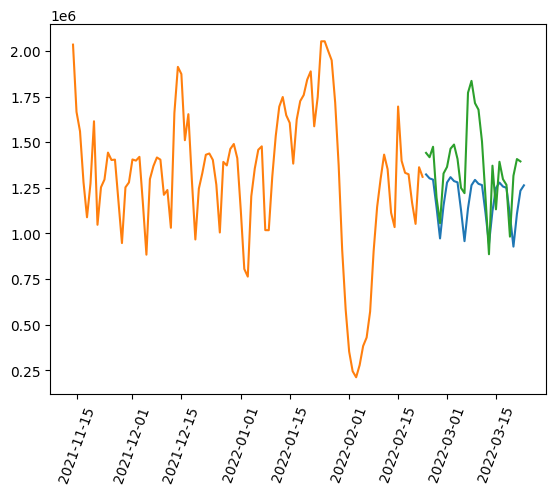

In [27]:
plt.plot(forecast_result[forecast_result['id']=='010Y'].ds, forecast_result[forecast_result['id']=='010Y'].pro_pred)
plt.plot(pd.to_datetime(traindf[traindf['id'].isin(['010Y'])].ds), traindf[traindf['id'].isin(['010Y'])].y)
plt.plot(pd.to_datetime(testdf[testdf['id'].isin(['010Y'])].ds), testdf[testdf['id'].isin(['010Y'])].y)

plt.xticks(rotation = 70)
plt.show()

In [46]:
forecast_result['version'] = 1
forecast_result['input_version'] = 'T+{}'.format(args['n_step'])
forecast_result['flags'] = 1
forecast_result['record_time'] = str(datetime.now())
forecast_result.rename(columns={'ds': 'predicted_datetime', 'pro_pred': 'predict_value', 'id': 'object_code'},inplace=True)
forecast_result['inc_day'] = forecast_result['predicted_datetime']
forecast_result['model_version'] = 'T{n_step}-prophet'.format(n_step=args['n_step'])
forecast_result['object_type'] = args['task_type']
forecast_result.reset_index(drop=True).to_csv('./output/dm_ordi_predict.zone_qty_predict_day_long_{}d.csv'.format(args['n_step']))